# Chapter 9

## Bivar 

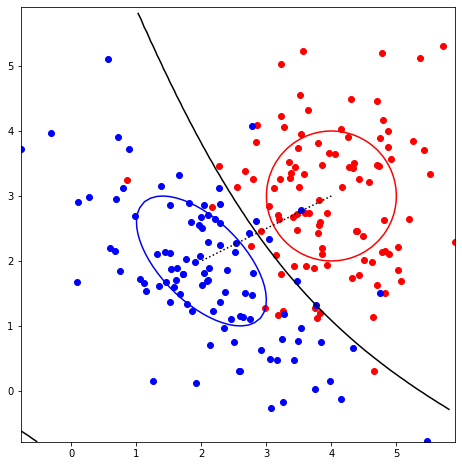

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def bivar(graphtype, mupos=None, sigpos=None, rhopos=None, muneg=None, signeg=None, rhoneg=None):

    if mupos is None:
        mupos = np.array([4, 4])
        sigpos = np.array([1, 1])
        rhopos = 0
        muneg = np.array([2, 2])
        sigmaneg = np.array([[1, -0.6], [-0.6, 1]])  
    else:
        sigmapos = np.array([[sigpos[0], rhopos * np.sqrt(sigpos[0] * sigpos[1])],
                             [rhopos * np.sqrt(sigpos[0] * sigpos[1]), sigpos[1]]])

        if signeg is None:
            sigmaneg = np.array([[1, -0.6], [-0.6, 1]])  
        else:
            sigmaneg = signeg

    Npos = 100
    Nneg = 100


    pos = np.random.multivariate_normal(mupos, sigmapos, Npos)
    neg = np.random.multivariate_normal(muneg, sigmaneg, Nneg)

    mn = np.min(np.concatenate((pos, neg), axis=0))
    mx = np.max(np.concatenate((pos, neg), axis=0))
    
    x = np.arange(mn, mx, 0.1)
    y = np.arange(mn, mx, 0.1)
    X, Y = np.meshgrid(x, y)

    Ppos = np.zeros_like(X)
    Pneg = np.zeros_like(X)
    L = np.zeros_like(X)

    for i in range(len(x)):
        for j in range(len(y)):
            Ppos[j, i] = getprob(x[i], y[j], mupos, sigmapos)
            Pneg[j, i] = getprob(x[i], y[j], muneg, sigmaneg)
            L[j, i] = Pneg[j, i] / Ppos[j, i]

    Pb = (1 / (2 * np.pi * np.sqrt(np.linalg.det(sigmapos)))) * np.exp(-1 / 2)
    Ps = (1 / (2 * np.pi * np.sqrt(np.linalg.det(sigmaneg)))) * np.exp(-1 / 2)


    plt.figure(figsize=(8, 8))
    if graphtype == 2:

        plt.axis('square')
        plt.axis([mn, mx, mn, mx])

        plt.scatter(pos[:, 0], pos[:, 1], color='r', label='Positive')
        plt.scatter(neg[:, 0], neg[:, 1], color='b', label='Negative')

        plt.contour(X, Y, Ppos, levels=[Pb], colors='r')
        plt.contour(X, Y, Pneg, levels=[Ps], colors='b')
        plt.contour(X, Y, L, levels=[1], colors='k')

        plt.plot([mupos[0], muneg[0]], [mupos[1], muneg[1]], color='k', linestyle=':')

    elif graphtype == 3:

        from mpl_toolkits.mplot3d import Axes3D

        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')

        ax.plot_surface(X, Y, Ppos, cmap='Reds', edgecolor='none', alpha=0.6)
        ax.plot_surface(X, Y, Pneg, cmap='Blues', edgecolor='none', alpha=0.6)

        ax.contour3D(X, Y, Ppos, levels=[Pb], cmap='Reds')
        ax.contour3D(X, Y, Pneg, levels=[Ps], cmap='Blues')

    plt.show()


def getprob(x, y, mu, sigma):
    vec = np.array([x, y])
    E = 2 * np.pi * np.sqrt(np.linalg.det(sigma))
    P = (1 / E) * np.exp(-0.5 * np.dot(np.dot((vec - mu), np.linalg.inv(sigma)), (vec - mu).T))
    return P

bivar(2, mupos=[4, 3], sigpos=[1, 1], rhopos=0, muneg=[2, 2], signeg=[[1, -0.6], [-0.6, 1]], rhoneg=0)

## Density 

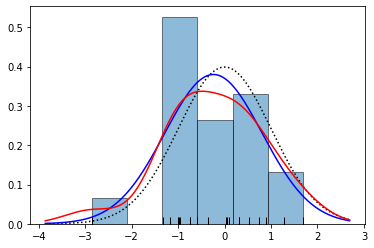

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import gaussian_kde

points = np.random.normal(size=20)

plt.hist(points, bins='auto', density=True, alpha=0.5, edgecolor='black')

plt.plot(points, np.zeros_like(points), '|', color='black', markersize=15)

x = np.linspace(min(points) - 1, max(points) + 1, 1000)
plt.plot(x, norm.pdf(x), linestyle='dotted', color='black')

mu = np.mean(points)
sigma = np.std(points, ddof=1)
plt.plot(x, norm.pdf(x, mu, sigma), color='blue')

kde = gaussian_kde(points)
plt.plot(x, kde(x), color='red')

plt.xlabel('')
plt.title('')

plt.show()

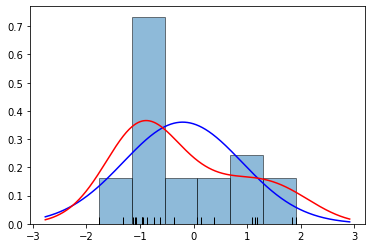

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import gaussian_kde

points = np.random.uniform(-2, 2, 20)

plt.hist(points, bins='auto', density=True, alpha=0.5, edgecolor='black')

plt.plot(points, np.zeros_like(points), '|', color='black', markersize=15)

mu = np.mean(points)
sigma = np.std(points, ddof=1)

x = np.linspace(min(points) - 1, max(points) + 1, 1000)
plt.plot(x, norm.pdf(x, mu, sigma), color='blue')

kde = gaussian_kde(points)
plt.plot(x, kde(x), color='red')

plt.xlabel('')
plt.title('')

plt.show()

## GMM

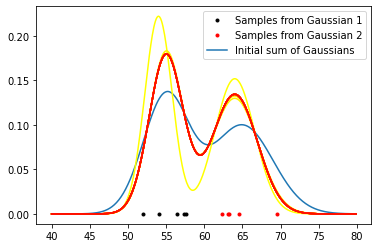

(array([55, 64]), array([4.99725208, 8.80882941]), array([50, 67]))

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def gmm(mu1=55, sigmasq1=9, mu2=65, sigmasq2=16):
    """
    Gaussian Mixture Model (GMM) using Expectation-Maximization (EM) algorithm.

    Args:
        mu1 (float): Mean of the first Gaussian distribution.
        sigmasq1 (float): Variance of the first Gaussian distribution.
        mu2 (float): Mean of the second Gaussian distribution.
        sigmasq2 (float): Variance of the second Gaussian distribution.

    Returns:
        tuple: Final means, variances, and initial means.
    """
    N1 = 5
    N2 = 5
    N = N1 + N2

    samples1 = np.random.normal(mu1, np.sqrt(sigmasq1), N1)
    samples2 = np.random.normal(mu2, np.sqrt(sigmasq2), N2)
    
    samples = np.sort(np.concatenate([samples1, samples2]))

    x = np.arange(40, 80, 0.1)

    P1 = (1 / np.sqrt(2 * np.pi * sigmasq1)) * np.exp(-((x - mu1) ** 2) / (2 * sigmasq1))
    P2 = (1 / np.sqrt(2 * np.pi * sigmasq2)) * np.exp(-((x - mu2) ** 2) / (2 * sigmasq2))

    plt.figure()
    plt.plot(samples1, np.zeros(len(samples1)), 'k.', label='Samples from Gaussian 1')
    plt.plot(samples2, np.zeros(len(samples2)), 'r.', label='Samples from Gaussian 2')
    plt.plot(x, P1 + P2, label='Initial sum of Gaussians')

    mu0 = np.sort(np.random.randint(50, 71, 2))
    mu = mu0.copy()
    sigmasq = np.array([1.0, 1.0])

    z = np.zeros((2, N))

    iterations = 20

    for k in range(iterations):
        for i in range(N):
            z1 = (1 / np.sqrt(2 * np.pi * sigmasq[0])) * np.exp(-((samples[i] - mu[0]) ** 2) / (2 * sigmasq[0]))
            z2 = (1 / np.sqrt(2 * np.pi * sigmasq[1])) * np.exp(-((samples[i] - mu[1]) ** 2) / (2 * sigmasq[1]))
            total = z1 + z2 + 1e-10 
            z[0, i] = z1 / total
            z[1, i] = z2 / total

        z1_sum = np.sum(z[0])
        z2_sum = np.sum(z[1])

        mu[0] = np.sum(samples * z[0]) / (z1_sum + 1e-10)
        mu[1] = np.sum(samples * z[1]) / (z2_sum + 1e-10)

        sigmasq[0] = np.sum(z[0] * (samples - mu[0]) ** 2) / (z1_sum + 1e-10)
        sigmasq[1] = np.sum(z[1] * (samples - mu[1]) ** 2) / (z2_sum + 1e-10)

        P1 = (1 / np.sqrt(2 * np.pi * sigmasq[0])) * np.exp(-((x - mu[0]) ** 2) / (2 * sigmasq[0]))
        P2 = (1 / np.sqrt(2 * np.pi * sigmasq[1])) * np.exp(-((x - mu[1]) ** 2) / (2 * sigmasq[1]))
        plt.plot(x, P1 + P2, color=[1, 1 - k / iterations, 0])

    plt.legend()
    plt.show()

    return mu, sigmasq, mu0

gmm()

## Lin Class 2

Error for BLC: 5
Error for LSC: 5
Optimization terminated successfully.
         Current function value: 0.080978
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  200
Model:                          Logit   Df Residuals:                      197
Method:                           MLE   Df Model:                            2
Date:                Wed, 16 Jul 2025   Pseudo R-squ.:                  0.8832
Time:                        11:21:04   Log-Likelihood:                -16.196
converged:                       True   LL-Null:                       -138.63
Covariance Type:            nonrobust   LLR p-value:                 6.725e-54
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2297      0.741      0.310      0.756      -1.222       

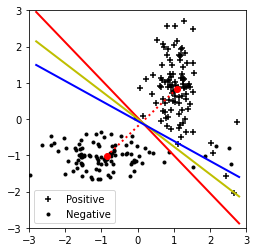

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

def linclass():
    mupos = np.array([1, 1])
    sigpos = np.array([0.1, 0.6])
    rhopos = 0.1
    mupos2 = np.array([2, -1])
    sigpos2 = np.array([0.2, 0.2])
    rhopos2 = 0
    muneg = np.array([-1, -1])
    signeg = np.array([0.6, 0.1])
    rhoneg = 0.1
    muneg2 = mupos2
    signeg2 = sigpos2
    rhoneg2 = rhopos2

    covpos = rhopos * np.sqrt(sigpos[0] * sigpos[1])
    sigmapos = np.array([[sigpos[0], covpos], [covpos, sigpos[1]]])
    
    covpos2 = rhopos2 * np.sqrt(sigpos2[0] * sigpos2[1])
    sigmapos2 = np.array([[sigpos2[0], covpos2], [covpos2, sigpos2[1]]])
    
    covneg = rhoneg * np.sqrt(signeg[0] * signeg[1])
    sigmaneg = np.array([[signeg[0], covneg], [covneg, signeg[1]]])
    
    covneg2 = rhoneg2 * np.sqrt(signeg2[0] * signeg2[1])
    sigmaneg2 = np.array([[signeg2[0], covneg2], [covneg2, signeg2[1]]])

    Npos = 100
    Npos2 = 5
    Nneg = 100
    Nneg2 = 5

    pos = np.vstack([np.random.multivariate_normal(mupos, sigmapos, Npos - Npos2),
                     np.random.multivariate_normal(mupos2, sigmapos2, Npos2)])
    
    neg = np.vstack([np.random.multivariate_normal(muneg, sigmaneg, Nneg - Nneg2),
                     np.random.multivariate_normal(muneg2, sigmaneg2, Nneg2)])

    plt.figure(1)
    plt.scatter(pos[:, 0], pos[:, 1], c='k', marker='+', label='Positive')
    plt.scatter(neg[:, 0], neg[:, 1], c='k', marker='.', label='Negative')
    plt.axis([-3, 3, -3, 3])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()

    pos1 = np.hstack([np.ones((Npos, 1)), pos])
    neg1 = np.hstack([np.ones((Nneg, 1)), neg])
    x = np.vstack([pos1, neg1])
    y = np.hstack([np.ones(Npos), np.zeros(Nneg)])

    xx = 2.8

    emupos1 = np.mean(pos1, axis=0)
    emuneg1 = np.mean(neg1, axis=0)
    blc = (emupos1 - emuneg1)
    blc[0] = -(emupos1 + emuneg1) @ blc / 2
    plt.plot(emupos1[1], emupos1[2], 'ro')
    plt.plot(emuneg1[1], emuneg1[2], 'ro')
    plt.plot([emupos1[1], emuneg1[1]], [emupos1[2], emuneg1[2]], 'r:', lw=2)
    plt.plot([-xx, xx], [(-blc[0] + xx * blc[1]) / blc[2], (-blc[0] - xx * blc[1]) / blc[2]], 'r-', lw=2)
    errblc = np.sum(pos1 @ blc < 0) + np.sum(neg1 @ blc > 0)
    print(f'Error for BLC: {errblc}')

    lsc = np.linalg.inv(np.vstack([pos1, neg1]).T @ np.vstack([pos1, neg1])) @ (Npos * emupos1 - Nneg * emuneg1)
    plt.plot([-xx, xx], [(-lsc[0] + xx * lsc[1]) / lsc[2], (-lsc[0] - xx * lsc[1]) / lsc[2]], 'y-', lw=2)
    errlsc = np.sum(pos1 @ lsc < 0) + np.sum(neg1 @ lsc > 0)
    print(f'Error for LSC: {errlsc}')

    x_logit = sm.add_constant(x)
    log_reg = sm.Logit(y, x_logit).fit()
    print(log_reg.summary())

    plt.plot([-xx, xx], [(-log_reg.params[0] + xx * log_reg.params[1]) / log_reg.params[2], 
                         (-log_reg.params[0] - xx * log_reg.params[1]) / log_reg.params[2]], 'b-', lw=2)

    errblr = np.sum(pos1 @ log_reg.params < 0) + np.sum(neg1 @ log_reg.params > 0)
    print(f'Error for Logistic Regression: {errblr}')

    Plr = log_reg.predict(x_logit)
    BSlr = np.mean((Plr - y) ** 2)
    print(f'Binary Logistic Regression Error: {BSlr}')

    plt.show()

linclass()

## Logreg

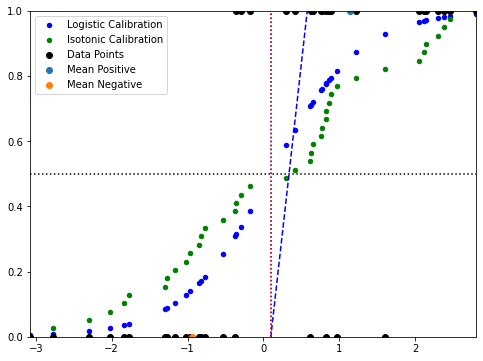

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import roc_curve, auc

mupos = 1
muneg = -1
Npos = 20
Nneg = 20
clr = Npos / Nneg

px = np.random.normal(mupos, 1, Npos)
nx = np.random.normal(muneg, 1, Nneg)
x = np.concatenate([px, nx])

py = np.ones(Npos)
ny = np.zeros(Nneg) 
y = np.concatenate([py, ny])

ymin = 0
ymax = 1
y0 = (ymin + ymax) / 2

xmin = np.min(x)
xmax = np.max(x)

X = np.vstack([np.ones_like(x), x]).T

emupos1 = np.mean(np.vstack([np.ones_like(px), px]), axis=1)
emuneg1 = np.mean(np.vstack([np.ones_like(nx), nx]), axis=1)
blc = (emupos1 - emuneg1)
blc = blc[:, np.newaxis]
blc[0] = -(emupos1 + emuneg1).dot(blc) / 2
B = blc.flatten()
x0 = np.mean([np.mean(px), np.mean(nx)])

plt.figure(figsize=(8, 6))
xaxis = np.arange(xmin, xmax, 0.1)
yminB = B[0] + B[1] * xmin
ymaxB = B[0] + B[1] * xmax
plt.plot(xaxis, B[0] + B[1] * xaxis, linestyle='--', color='b')
plt.axis([xmin, xmax, ymin, ymax])
plt.axhline(y0, linestyle=':', color='k')

w = B[1]
dpos = w * (px - x0)
dneg = w * (nx - x0)
d = np.concatenate([dpos, dneg])
mdpos = np.mean(dpos)
mdneg = np.mean(dneg)
vard = np.var(np.concatenate([dpos - mdpos, dneg - mdneg]), ddof=1)
a = (mdpos - mdneg) / vard
d0 = (mdpos + mdneg) / 2

plt.axvline(x0, linestyle=':', color='b')
LR = np.exp(a * (d - d0))
P = LR / (LR + Nneg / Npos)
plt.scatter(x, P, color='b', s=20, label='Logistic Calibration')

scoresPN = B[0] + np.concatenate([px, nx]) * B[1]
sortedScores = np.sort(scoresPN)[::-1]
index = np.argsort(scoresPN)[::-1]
CHprobs = np.interp(sortedScores, np.sort(sortedScores), np.linspace(0, 1, Npos + Nneg))
PCH = CHprobs
plt.scatter(x[index], PCH, color='g', s=20, label='Isotonic Calibration')

X_reg = np.vstack([np.ones_like(x), x]).T 
y_reg = y 

lr = LogisticRegression(fit_intercept=False)
lr.fit(X_reg, y_reg)
PLR = lr.predict_proba(X_reg)[:, 1]

yup2 = np.min(PLR[PLR > 0.5])
xup2 = x[np.min(np.where(PLR == yup2))]
ydn2 = np.max(PLR[PLR < 0.5])
xdn2 = x[np.max(np.where(PLR == ydn2))]
x2 = xdn2 + (xup2 - xdn2) * (1 / 2 - ydn2) / (yup2 - ydn2)

plt.axvline(x2, linestyle=':', color='r')

fp2 = Npos - np.sum(y_reg[X_reg[:, 1] > x2] == 1)
fn2 = np.sum(y_reg[X_reg[:, 1] > x2] == 0)
err2 = fp2 + fn2
BS2 = np.mean((PLR - y_reg) ** 2)

plt.scatter(x, y, color='k', label='Data Points')
plt.scatter(np.mean(px), ymax, label='Mean Positive')
plt.scatter(np.mean(nx), ymin, label='Mean Negative')

plt.legend()
plt.show()